In [255]:
import numpy as np
import pandas as pd
import scipy.stats as st
import matplotlib.pyplot as plt
import seaborn as sns
import os as os
import statsmodels.api as sm
import statsmodels.regression.linear_model as lm
sys.path.append('../../')
import Constants as c
import Utilities as utils
from sklearn.preprocessing import RobustScaler
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import ExtraTreesRegressor
from sklearn.compose import TransformedTargetRegressor
from sklearn.ensemble import AdaBoostRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.compose import TransformedTargetRegressor
from sklearn.pipeline import Pipeline
from sklearn.neural_network import MLPRegressor
from sklearn.isotonic import IsotonicRegression
from sklearn.neighbors import KNeighborsRegressor
from sklearn.svm import SVR
from sklearn.kernel_ridge import KernelRidge
from sklearn.linear_model import LinearRegression
from sklearn import model_selection
from sklearn.model_selection import cross_val_predict
from sklearn.linear_model import RidgeCV
from sklearn import metrics
from statsmodels.stats.outliers_influence import variance_inflation_factor
sns.set_style("darkgrid")
%matplotlib inline

In [256]:
regressors = {
  "DecisionTreeRegressor": DecisionTreeRegressor(random_state=0),
  "RandomForestRegressor": RandomForestRegressor(random_state=0),
  "AdaBoostRegressor": AdaBoostRegressor(random_state=0),
  "GradientBoostingRegressor": GradientBoostingRegressor(random_state=0),
  "ExtraTreesRegressor": ExtraTreesRegressor(random_state=0),
  "KNeighborsRegressor": KNeighborsRegressor(),
  "IsotonicRegression": IsotonicRegression(),
  "KernelRidge": KernelRidge(),
  "MLPRegressor": MLPRegressor(random_state=0),
  "SVR": SVR(),
  "LinearRegression": LinearRegression(),
  "RidgeCV": RidgeCV()
}

transformers = {
  "RobustScaler": RobustScaler(),
  "StandardScaler": StandardScaler(),
  "MinMaxScaler": MinMaxScaler()
}

regressor = regressors["LinearRegression"]
transformer = transformers["RobustScaler"]

In [257]:
project_name = "linux"
file = "../../output/{0}_version_metrics.csv".format(project_name)
# file = "../../output/{0}_version_metrics_major_versions.csv".format(project_name)
df = pd.read_csv(file)

df["E_Line"] = df["E_Line"].astype(str).astype(int)
df["E_Module"] = df["E_Module"].astype(str).astype(int)
df = df.rename(columns={"T_Line": "T_Line_Original", "T_Module": "T_Module_Original"})
df["T_Line"] = df["T_Line_Original"].shift()
df["T_Module"] = df["T_Module_Original"].shift()
df = df[[c.VERSION, c.NT, c.NO, "E_Line", "E_Module", c.T_LINE, c.T_MODULE]]

print(len(df))

if df.isna().values.any():
    df.fillna(0, inplace=True)

df = df.apply(lambda x: np.log1p(x) if np.issubdtype(x.dtype, np.number) else x)
# df["E_Line"] = utils.log_transform(df, "E_Line")
# df["E_Module"] = utils.log_transform(df, "E_Module")

df.replace([np.inf, -np.inf], 0, inplace=True)

print(len(df))

df.head()

638
638


,Version,NT,NO,E_Line,E_Module,T_Line,T_Module
0,v2.6.12-rc2,0.000000,0.000000,11.874954,7.721349,0.000000,0.000000
1,v2.6.12-rc3,4.276666,5.594711,10.671000,6.378426,15.720477,9.757999
2,v2.6.12-rc4,4.934474,6.411818,10.781827,7.167809,15.723365,9.759502
3,v2.6.12-rc5,4.158883,5.225747,9.776847,5.802118,15.725946,9.761348
4,v2.6.12-rc6,4.174387,5.641907,10.401896,5.843544,15.726508,9.762039


In [258]:
# print out a correlation matrix of our data frame
corr = df.corr(method="pearson")

# display it
display(corr)

,NT,NO,E_Line,E_Module,T_Line,T_Module
NT,1.000000,0.992751,0.283623,0.217901,0.068008,0.056452
NO,0.992751,1.000000,0.281784,0.211255,0.068327,0.056554
E_Line,0.283623,0.281784,1.000000,0.958942,-0.121543,-0.142406
E_Module,0.217901,0.211255,0.958942,1.000000,-0.053296,-0.056812
T_Line,0.068008,0.068327,-0.121543,-0.053296,1.000000,0.980730
T_Module,0.056452,0.056554,-0.142406,-0.056812,0.980730,1.000000


Text(0.5, 1.0, 'Correlation Plot - Linux Project')

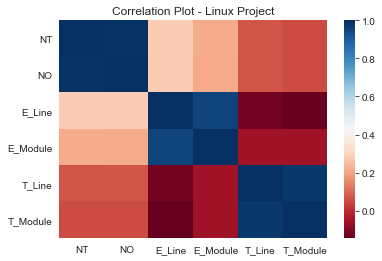

In [259]:
ax = sns.heatmap(corr, xticklabels=corr.columns, yticklabels=corr.columns, cmap='RdBu')
ax.set_title('Correlation Plot - Linux Project')

Text(0.5, 1.0, 'NT vs. E_Line - linux')

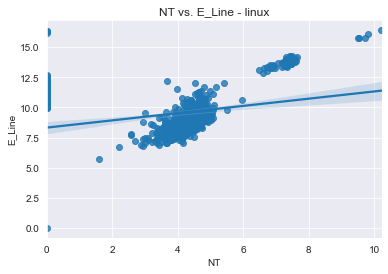

In [260]:
sns.set_style("darkgrid")
line_effort = sns.regplot(x=c.NT, y="E_Line", data=df)
plt.title('NT vs. E_Line - {0}'.format(project_name))

Text(0.5, 1.0, 'NO vs. E_Line - linux')

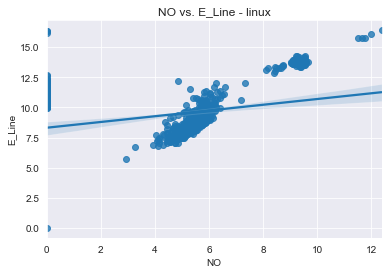

In [261]:
sns.set_style("darkgrid")
line_effort = sns.regplot(x=c.NO, y="E_Line", data=df)
plt.title('NO vs. E_Line - {0}'.format(project_name))

Text(0.5, 1.0, 'NT vs. E_Module - linux')

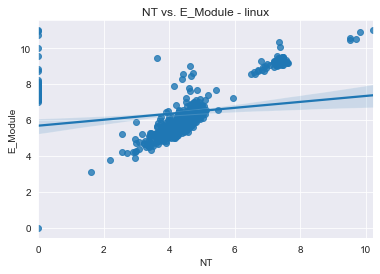

In [262]:
sns.set_style("darkgrid")
line_effort = sns.regplot(x=c.NT, y="E_Module", data=df)
plt.title('NT vs. E_Module - {0}'.format(project_name))

Text(0.5, 1.0, 'NO vs. E_Module - linux')

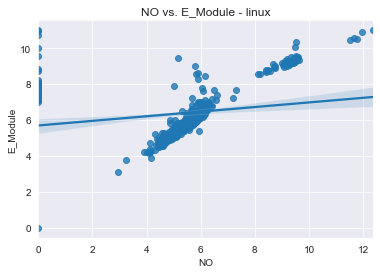

In [263]:
sns.set_style("darkgrid")
line_effort = sns.regplot(x=c.NO, y="E_Module", data=df)
plt.title('NO vs. E_Module - {0}'.format(project_name))

Text(0.5, 1.0, 'T_Module vs. E_Module - linux')

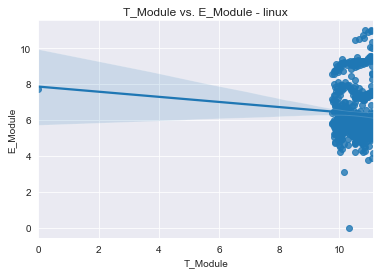

In [264]:
sns.set_style("darkgrid")
line_effort = sns.regplot(x=c.T_MODULE, y="E_Module", data=df)
plt.title('T_Module vs. E_Module - {0}'.format(project_name))

In [265]:
X = df[[c.NT, c.NO]]
Y = df['E_Line']

splits = 10
num_records = len(X)

if num_records <= splits:
    splits = num_records

# pipeline = Pipeline(steps=[('scaler', transformer), ('predictor', regressor)])
# model = TransformedTargetRegressor(regressor=pipeline, transformer=transformer)
model = regressor
model.fit(X, Y)

kfold = model_selection.KFold(n_splits=splits)
predictions = cross_val_predict(model, X, Y, cv=kfold)
# Interpreting Restuls:  https://www.youtube.com/watch?v=U7D1h5bbpcs  

In [266]:
# 1st Assumption of Linearity:  Multicollinearity Test
vif = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
pd.DataFrame({'vif': vif[0:]}, index=X.columns).T

,NT,NO
vif,383.469309,383.469309


In [267]:
results = utils.create_percent_error_df
results = utils.create_percent_error_df(Y, predictions)
results['Version'] = np.arange(results.__len__())
results

,Observed,Predicted,Difference,Percent_Error,Version
0,11.87,8.17,3.71,0.31,0
1,10.67,9.55,1.12,0.11,1
2,10.78,9.76,1.02,0.09,2
3,9.78,9.49,0.28,0.03,3
4,10.40,9.53,0.87,0.08,4
...,...,...,...,...,...
633,8.42,9.68,1.26,0.15,633
634,13.53,10.31,3.23,0.24,634
635,9.58,9.63,0.05,0.01,635
636,9.05,9.67,0.62,0.07,636


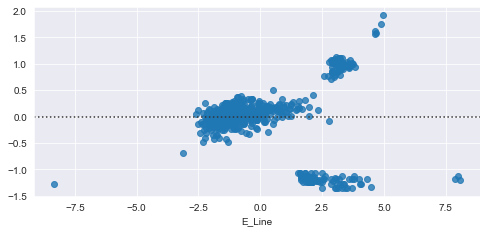

In [268]:
# 2nd Assumption of Linearity:  Homoscedasticity Test
fig, ax = plt.subplots(figsize=(8,3.5))
pred_val = predictions
true_val = Y
residuals = true_val - pred_val
sns.residplot(residuals, pred_val)

In [269]:
residuals.mean()

-0.0010207122208814577

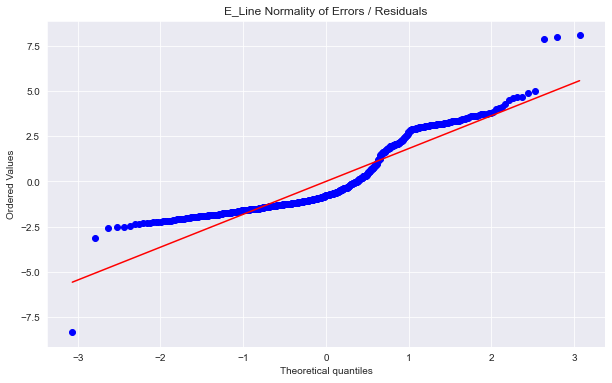

In [270]:
# 3rd Assumption of Linearity:  Normality of Errors / Residuals Test
fig, ax = plt.subplots(figsize=(10,6))
st.probplot(residuals, dist='norm', plot=plt)
plt.title('E_Line Normality of Errors / Residuals')
plt.show()

Text(0.5, 1.0, 'E_Line Normality of Errors / Residuals')

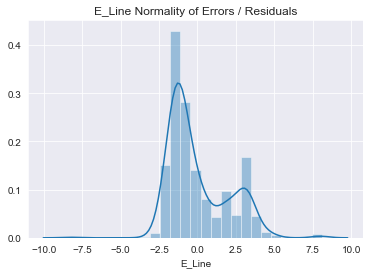

In [271]:
# 3rd Assumption of Linearity:  Normality of Errors / Residuals Test
sns.distplot(residuals)
plt.title('E_Line Normality of Errors / Residuals')

In [272]:
pred25 = utils.calculate_PRED(0.25, results, c.PERCENT_ERROR)
print("PRED (25): " + "{:.2%}".format(pred25))

pred50 = utils.calculate_PRED(0.50, results, c.PERCENT_ERROR)
print("PRED (50): " + "{:.2%}".format(pred50))

PRED (25): 85.00%
PRED (50): 100.00%


In [273]:
print("MAE: {0}".format(metrics.mean_absolute_error(Y, predictions)))
print("R^2: {0}".format(metrics.r2_score(Y, predictions)))

MAE: 1.5994535460148844
R^2: 0.06631928524974451


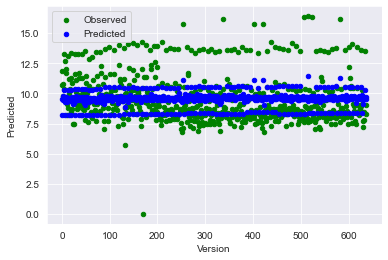

In [274]:
ax = results.plot(kind='scatter', x='Version', y='Observed', c='green', label='Observed')
results.plot(kind='scatter', x='Version', y='Predicted', c='blue', label='Predicted', ax=ax)

In [275]:
# partialRegPlot = plt.figure(figsize=(15,8))
# partialRegPlot = sm.graphics.regressionplots.plot_partregress_grid(model, fig=partialRegPlot)

In [276]:
# regPlotNC = plt.figure(figsize=(15,8))
# regPlotNC = sm.graphics.regressionplots.plot_regress_exog(model, c.NT, fig=regPlotNC)

In [277]:
# regPlotNO = plt.figure(figsize=(15,8))
# regPlotNO = sm.graphics.regressionplots.plot_regress_exog(model, c.NO, fig=regPlotNO)

In [278]:
X = df[[c.NT, c.NO, c.T_MODULE]]
Y = df['E_Module']

# pipeline = Pipeline(steps=[('scaler', transformer), ('predictor', regressor)])
# model = TransformedTargetRegressor(regressor=pipeline, transformer=transformer)
model = regressor
fitted_values = model.fit(X, Y)

kfold = model_selection.KFold(n_splits=splits)
predictions = cross_val_predict(model, X, Y, cv=kfold)

In [279]:
# 1st Assumption of Linearity:  Multicollinearity Test
vif = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
pd.DataFrame({'vif': vif[0:]}, index=X.columns).T

,NT,NO,T_Module
vif,384.542161,393.723101,5.701807


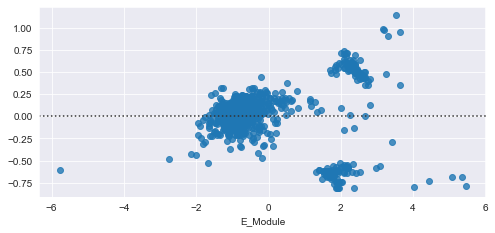

In [280]:
# 2nd Assumption of Linearity:  Homoscedasticity Test
fig, ax = plt.subplots(figsize=(8,3.5))
pred_val = predictions
true_val = Y
residuals = true_val - pred_val
sns.residplot(residuals, pred_val)

In [281]:
residuals.mean()

0.011727214855627603

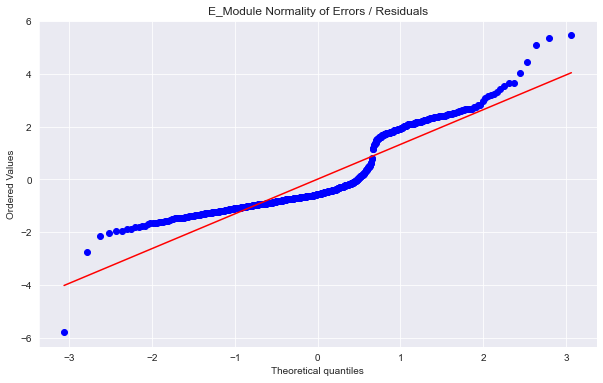

In [282]:
# 3rd Assumption of Linearity:  Normality of Errors / Q-Q Plot
fig, ax = plt.subplots(figsize=(10,6))
st.probplot(residuals, dist='norm', plot=plt)
plt.title('E_Module Normality of Errors / Residuals')
plt.show()

Text(0.5, 1.0, 'E_Module Normality of Errors / Residuals')

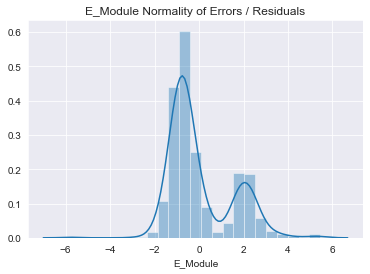

In [283]:
# 3rd Assumption of Linearity:  Normality of Errors / Residuals Test
sns.distplot(residuals)
plt.title('E_Module Normality of Errors / Residuals')

In [284]:
data = {}
data[c.OBSERVED] = Y.round(2)
results = utils.create_percent_error_df(Y, predictions)
results['Version'] = np.arange(results.__len__())
results

,Observed,Predicted,Difference,Percent_Error,Version
0,7.72,6.39,1.33,0.17,0
1,6.38,6.41,0.04,0.01,1
2,7.17,6.53,0.64,0.09,2
3,5.80,6.42,0.62,0.11,3
4,5.84,6.37,0.53,0.09,4
...,...,...,...,...,...
633,5.68,6.30,0.62,0.11,633
634,9.28,6.46,2.82,0.30,634
635,5.95,6.20,0.25,0.04,635
636,6.02,6.24,0.22,0.04,636


In [285]:
pred25 = utils.calculate_PRED(0.25, results, c.PERCENT_ERROR)
print("PRED (25): " + "{:.2%}".format(pred25))

pred50 = utils.calculate_PRED(0.50, results, c.PERCENT_ERROR)
print("PRED (50): " + "{:.2%}".format(pred50))

PRED (25): 76.00%
PRED (50): 99.00%


In [286]:
print("MAE: {0}".format(metrics.mean_absolute_error(Y, predictions)))
print("R^2 (Predicted): {0}".format(metrics.r2_score(Y, predictions)))

MAE: 1.1477445492709413
R^2 (Predicted): 0.04160954245866233


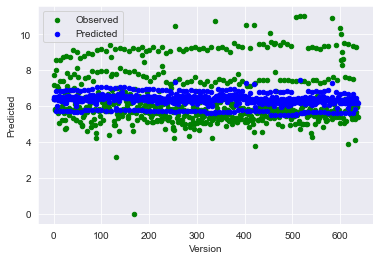

In [287]:
ax = results.plot(kind='scatter', x='Version', y='Observed', c='green', label='Observed')
results.plot(kind='scatter', x='Version', y='Predicted', c='blue', label='Predicted', ax=ax)

In [288]:
# partialRegPlot = plt.figure(figsize=(15,8))
# partialRegPlot = sm.graphics.regressionplots.plot_partregress_grid(model, fig=partialRegPlot)

In [289]:
# regPlotNC = plt.figure(figsize=(15,8))
# regPlotNC = sm.graphics.regressionplots.plot_regress_exog(model, c.NT, fig=regPlotNC)

In [290]:
# regPlotNO = plt.figure(figsize=(15,8))
# regPlotNO = sm.graphics.regressionplots.plot_regress_exog(model, c.NO, fig=regPlotNO)